In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc,
)
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.pipeline import Pipeline
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score

In [2]:
training_file = "wildfires_training.csv"
test_file = "wildfires_test.csv"

df = pd.read_csv("wildfires_training.csv")
df_test = pd.read_csv("wildfires_test.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154 entries, 0 to 153
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   fire           154 non-null    object 
 1   year           154 non-null    int64  
 2   temp           154 non-null    int64  
 3   humidity       154 non-null    int64  
 4   rainfall       154 non-null    float64
 5   drought_code   154 non-null    float64
 6   buildup_index  154 non-null    float64
 7   day            154 non-null    int64  
 8   month          154 non-null    int64  
 9   wind_speed     154 non-null    int64  
dtypes: float64(3), int64(6), object(1)
memory usage: 12.2+ KB


In [4]:
df.describe()

,year,temp,humidity,rainfall,drought_code,buildup_index,day,month,wind_speed
count,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000
mean,2012.058442,31.545455,63.071429,0.855844,48.146299,16.285065,15.077922,7.603896,16.383117
std,3.355294,3.952481,16.038804,2.246798,47.348331,14.346991,8.085760,1.217620,3.218001
min,2007.000000,22.000000,21.000000,0.000000,7.180000,1.320000,1.000000,6.000000,6.000000
25%,2009.000000,29.000000,52.000000,0.000000,9.720000,5.797500,9.000000,6.000000,14.000000
50%,2012.000000,31.000000,64.000000,0.000000,31.330000,11.450000,15.000000,8.000000,16.000000
75%,2015.000000,34.000000,77.000000,0.600000,65.257500,22.775000,21.000000,9.000000,18.750000
max,2017.000000,43.000000,92.000000,16.800000,221.350000,67.720000,31.000000,9.000000,30.000000


In [5]:
df.shape

(154, 10)

In [6]:
dependent_variable = "fire"
independent_variables = [col for col in df.columns if col != dependent_variable]

In [7]:
# Training predictors and response variables
X_training = df[independent_variables]
y_training = df[dependent_variable] == "yes"

In [8]:
X_test = df_test[independent_variables]
y_test = df_test[dependent_variable] == "yes"

array([[<Axes: xlabel='year', ylabel='year'>,
        <Axes: xlabel='temp', ylabel='year'>,
        <Axes: xlabel='humidity', ylabel='year'>,
        <Axes: xlabel='rainfall', ylabel='year'>,
        <Axes: xlabel='drought_code', ylabel='year'>,
        <Axes: xlabel='buildup_index', ylabel='year'>,
        <Axes: xlabel='day', ylabel='year'>,
        <Axes: xlabel='month', ylabel='year'>,
        <Axes: xlabel='wind_speed', ylabel='year'>],
       [<Axes: xlabel='year', ylabel='temp'>,
        <Axes: xlabel='temp', ylabel='temp'>,
        <Axes: xlabel='humidity', ylabel='temp'>,
        <Axes: xlabel='rainfall', ylabel='temp'>,
        <Axes: xlabel='drought_code', ylabel='temp'>,
        <Axes: xlabel='buildup_index', ylabel='temp'>,
        <Axes: xlabel='day', ylabel='temp'>,
        <Axes: xlabel='month', ylabel='temp'>,
        <Axes: xlabel='wind_speed', ylabel='temp'>],
       [<Axes: xlabel='year', ylabel='humidity'>,
        <Axes: xlabel='temp', ylabel='humidity'>,
        

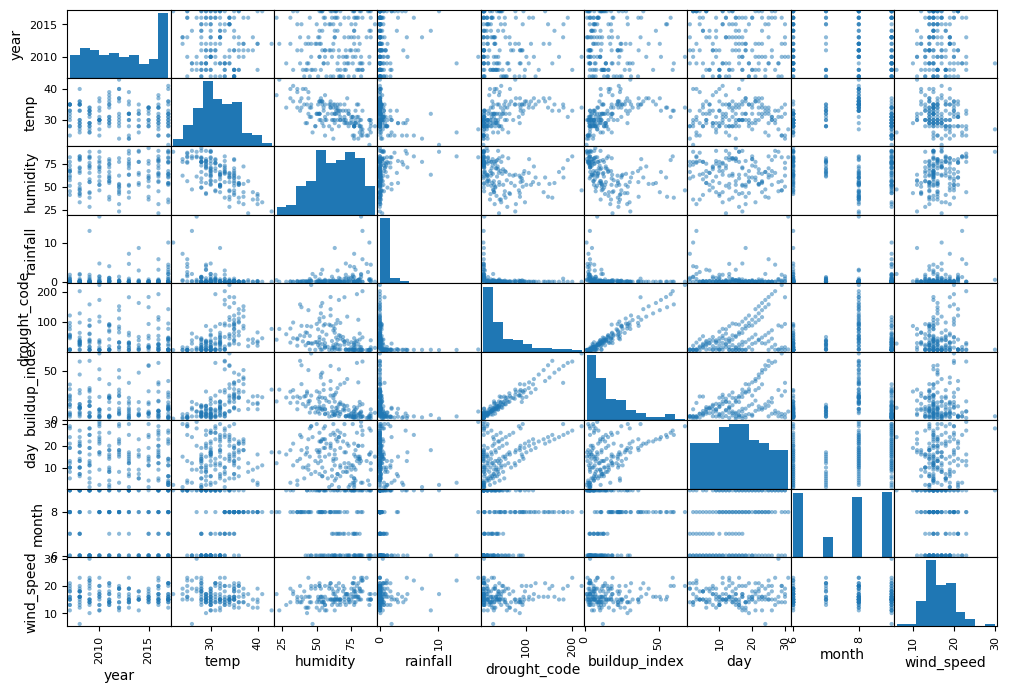

In [9]:
pd.plotting.scatter_matrix(X_training, figsize=(12, 8))

## Pre-Processing

In [10]:
# Interaction Terms
df["temp_humidity"] = df["temp"] * df["humidity"]
df["wind_bui"] = df["wind_speed"] * df["buildup_index"]

df_test["temp_humidity"] = df_test["temp"] * df_test["humidity"]
df_test["wind_bui"] = df_test["wind_speed"] * df_test["buildup_index"]

In [11]:
# Time to re-run with Hyper-parameter tuning
penalties = ["l1", "l2", "elasticnet", None]
c_values = np.logspace(-3, 3, 100)

In [12]:
training_test_comparison = {}

for penalty in penalties:
    models_info = []
    for c in c_values:
        l1_ratio = 0.3 if penalty == "elasticnet" else None

        if penalty == "l1":
            solver = "liblinear"
        elif penalty == "elasticnet":
            solver = "saga"
        else:
            solver = "lbfgs"

        logreg_pipe = Pipeline(
            [
                ("scaler", StandardScaler()),
                (
                    "logreg",
                    LogisticRegression(
                        random_state=42,
                        penalty=penalty,
                        solver=solver,
                        max_iter=5000,
                        C=c if penalty is not None else 1.0,
                        l1_ratio=l1_ratio,
                    ),
                ),
            ]
        )

        logreg_pipe.fit(X_training, y_training)
        predictions_training = logreg_pipe.predict(X_training)
        predictions_test = logreg_pipe.predict(X_test)

        accuracy_training = metrics.accuracy_score(y_training, predictions_training)
        accuracy_test = metrics.accuracy_score(y_test, predictions_test)

        y_probs = logreg_pipe.predict_proba(X_test)[:, 1]

        models_info.append(
            {
                "C": c,
                "training_accuracy": accuracy_training,
                "test_accuracy": accuracy_test,
                "pipeline": logreg_pipe,
                "predictions_test": predictions_test,
                "coefficients": logreg_pipe.named_steps["logreg"].coef_,
            }
        )

    # Save all models for this penalty
    training_test_comparison[penalty] = models_info

In [13]:
best_model = {}
for pen in penalties:
    best_model[pen] = max(
        training_test_comparison[pen], key=lambda x: x["test_accuracy"]
    )

In [14]:
# Print nicely
for penalty, model in best_model.items():
    print(f"Best {penalty if penalty else '(Without Regularization)'} model:")
    print(f"  C = {model['C']}")
    print(f"  Training Accuracy = {model['training_accuracy']:.4f}")
    print(f"  Test Accuracy = {model['test_accuracy']:.4f}\n")

Best l1 model:
  C = 247.7076355991714
  Training Accuracy = 0.9221
  Test Accuracy = 0.9000

Best l2 model:
  C = 15.199110829529332
  Training Accuracy = 0.9221
  Test Accuracy = 0.9000

Best elasticnet model:
  C = 11.497569953977356
  Training Accuracy = 0.9221
  Test Accuracy = 0.9000

Best (Without Regularization) model:
  C = 0.001
  Training Accuracy = 0.9286
  Test Accuracy = 0.9000



## Comparison Graphs
Below are graphs showing the effect of penalty functions and C Values (Lambda Inverse) on Logistic Regression

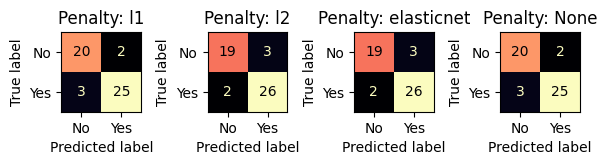

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(6, 6))
ax = ax.flatten()

for i, (penalty, model_info) in enumerate(best_model.items()):
    y_pred = model_info["predictions_test"]

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No", "Yes"])
    disp.plot(cmap="magma", ax=ax[i], colorbar=False)
    disp.ax_.set_title(f"Penalty: {penalty}")

plt.tight_layout()
plt.show()

### Training and Test Set Accuracy

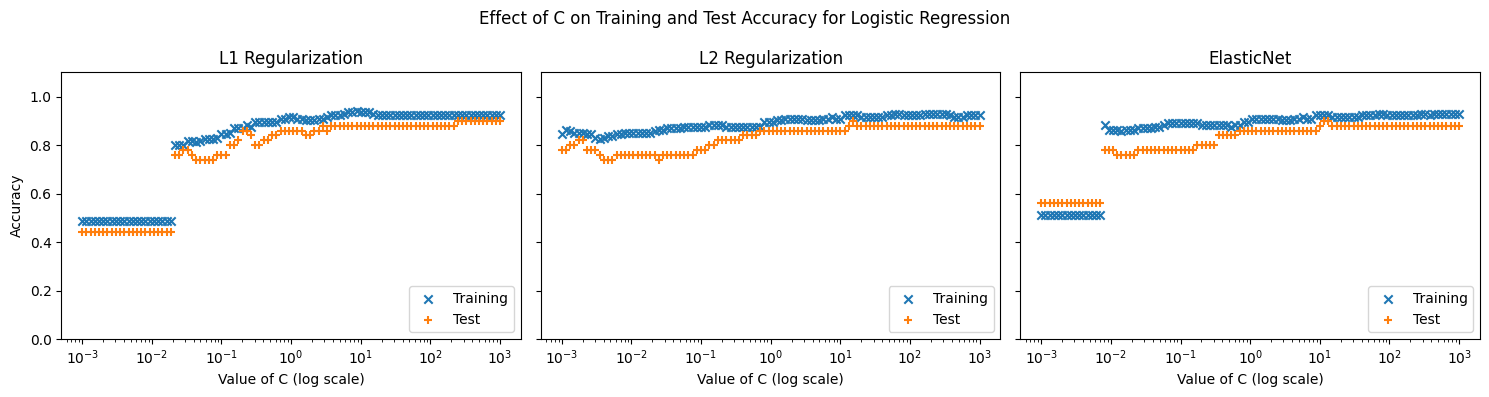

In [16]:
# Extract results
l1 = training_test_comparison["l1"]
l2 = training_test_comparison["l2"]
elasticnet = training_test_comparison["elasticnet"]

accuracy_training_l1 = [el["training_accuracy"] for el in l1]
accuracy_test_l1 = [el["test_accuracy"] for el in l1]

accuracy_training_l2 = [el["training_accuracy"] for el in l2]
accuracy_test_l2 = [el["test_accuracy"] for el in l2]

accuracy_training_elasticnet = [el["training_accuracy"] for el in elasticnet]
accuracy_test_elasticnet = [el["test_accuracy"] for el in elasticnet]

# Create 3 subplots (1 row, 3 columns)
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

# ---- L1 ----
axes[0].scatter(c_values, accuracy_training_l1, marker="x")
axes[0].scatter(c_values, accuracy_test_l1, marker="+")
axes[0].set_xscale("log")
axes[0].set_ylim([0.0, 1.1])
axes[0].set_xlabel("Value of C (log scale)")
axes[0].set_ylabel("Accuracy")
axes[0].set_title("L1 Regularization")
axes[0].legend(["Training", "Test"], loc=4)

# ---- L2 ----
axes[1].scatter(c_values, accuracy_training_l2, marker="x")
axes[1].scatter(c_values, accuracy_test_l2, marker="+")
axes[1].set_xscale("log")
axes[1].set_ylim([0.0, 1.1])
axes[1].set_xlabel("Value of C (log scale)")
axes[1].set_title("L2 Regularization")
axes[1].legend(["Training", "Test"], loc=4)

# ---- ElasticNet ----
axes[2].scatter(c_values, accuracy_training_elasticnet, marker="x")
axes[2].scatter(c_values, accuracy_test_elasticnet, marker="+")
axes[2].set_xscale("log")
axes[2].set_ylim([0.0, 1.1])
axes[2].set_xlabel("Value of C (log scale)")
axes[2].set_title("ElasticNet")
axes[2].legend(["Training", "Test"], loc=4)

# Adjust layout
plt.suptitle(
    "Effect of C on Training and Test Accuracy for Logistic Regression", fontsize=12
)
plt.tight_layout()
plt.show()

### Coefficient Magnitudes Vs C

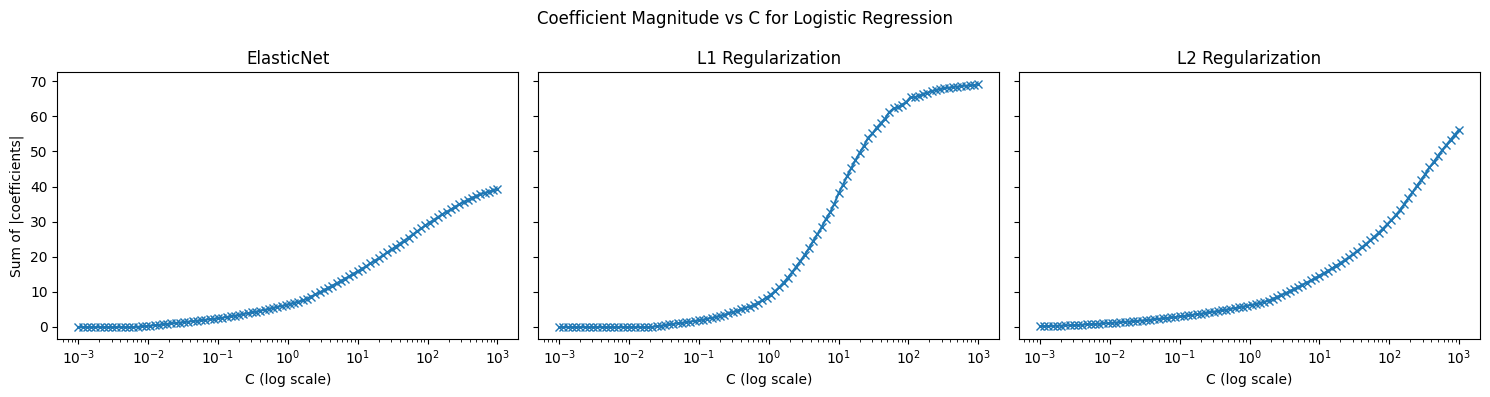

In [17]:
# Compute coefficient norms
coef_norms_elasticnet = [np.sum(np.abs(el["coefficients"])) for el in elasticnet]
coef_norms_l1 = [np.sum(np.abs(el["coefficients"])) for el in l1]
coef_norms_l2 = [np.sum(np.abs(el["coefficients"])) for el in l2]

# Create 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

# ---- ElasticNet ----
axes[0].plot(c_values, coef_norms_elasticnet, marker="x")
axes[0].set_xscale("log")
axes[0].set_xlabel("C (log scale)")
axes[0].set_ylabel("Sum of |coefficients|")
axes[0].set_title("ElasticNet")

# ---- L1 ----
axes[1].plot(c_values, coef_norms_l1, marker="x")
axes[1].set_xscale("log")
axes[1].set_xlabel("C (log scale)")
axes[1].set_title("L1 Regularization")

# ---- L2 ----
axes[2].plot(c_values, coef_norms_l2, marker="x")
axes[2].set_xscale("log")
axes[2].set_xlabel("C (log scale)")
axes[2].set_title("L2 Regularization")

# Adjust layout
plt.suptitle("Coefficient Magnitude vs C for Logistic Regression", fontsize=12)
plt.tight_layout()
plt.show()

### Coefficient Sparsity

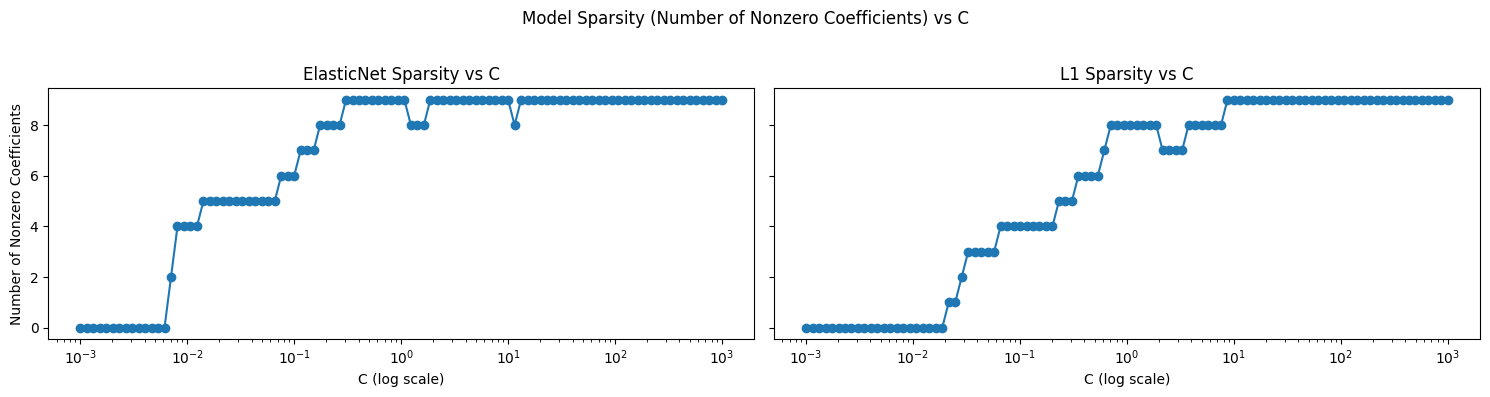

In [18]:
# Compute number of nonzero coefficients
num_nonzero_elasticnet = [np.count_nonzero(el["coefficients"]) for el in elasticnet]
num_nonzero_l1 = [np.count_nonzero(el["coefficients"]) for el in l1]
num_nonzero_l2 = [np.count_nonzero(el["coefficients"]) for el in l2]

# Create 3 subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 4), sharey=True)

# ---- ElasticNet ----
axes[0].plot(c_values, num_nonzero_elasticnet, marker="o")
axes[0].set_xscale("log")
axes[0].set_xlabel("C (log scale)")
axes[0].set_ylabel("Number of Nonzero Coefficients")
axes[0].set_title("ElasticNet Sparsity vs C")

# ---- L1 ----
axes[1].plot(c_values, num_nonzero_l1, marker="o")
axes[1].set_xscale("log")
axes[1].set_xlabel("C (log scale)")
axes[1].set_title("L1 Sparsity vs C")

# Adjust layout
plt.suptitle("Model Sparsity (Number of Nonzero Coefficients) vs C", fontsize=12)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### ROC Curve

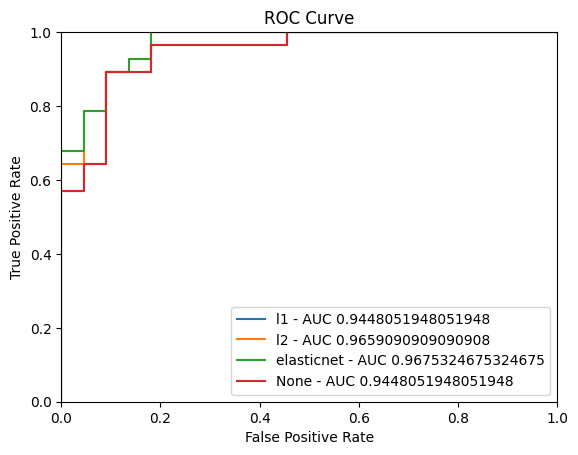

In [19]:
for i, pen in enumerate(["l1", "l2", "elasticnet", None]):
    best_model = max(training_test_comparison[pen], key=lambda x: x["test_accuracy"])
    y_probs = best_model["pipeline"].predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    plt.plot(fpr, tpr, label=f"{pen} - AUC {auc(fpr, tpr)}")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.title("ROC Curve")

In [20]:
# Collect rows for the table
rows = []

for pen in ["l1", "l2", "elasticnet", None]:
    # pick best model by test accuracy
    best_model = max(training_test_comparison[pen], key=lambda x: x["test_accuracy"])

    # classification report as dictionary
    report = classification_report(
        y_test, best_model["predictions_test"], output_dict=True
    )

    # Get overall accuracy
    acc = accuracy_score(y_test, best_model["predictions_test"])

    # Add row for table
    rows.append(
        {
            "Regularization": pen.upper()
            if isinstance(pen, str)
            else "No Regularization",
            "Precision (False)": round(report["False"]["precision"], 2),
            "Recall (False)": round(report["False"]["recall"], 2),
            "Precision (True)": round(report["True"]["precision"], 2),
            "Recall (True)": round(report["True"]["recall"], 2),
            "Accuracy": round(acc, 2),
        }
    )

# Create DataFrame
results_df = pd.DataFrame(rows)

print(results_df.to_string(index=False))

   Regularization  Precision (False)  Recall (False)  Precision (True)  Recall (True)  Accuracy
               L1               0.87            0.91              0.93           0.89       0.9
               L2               0.90            0.86              0.90           0.93       0.9
       ELASTICNET               0.90            0.86              0.90           0.93       0.9
No Regularization               0.87            0.91              0.93           0.89       0.9


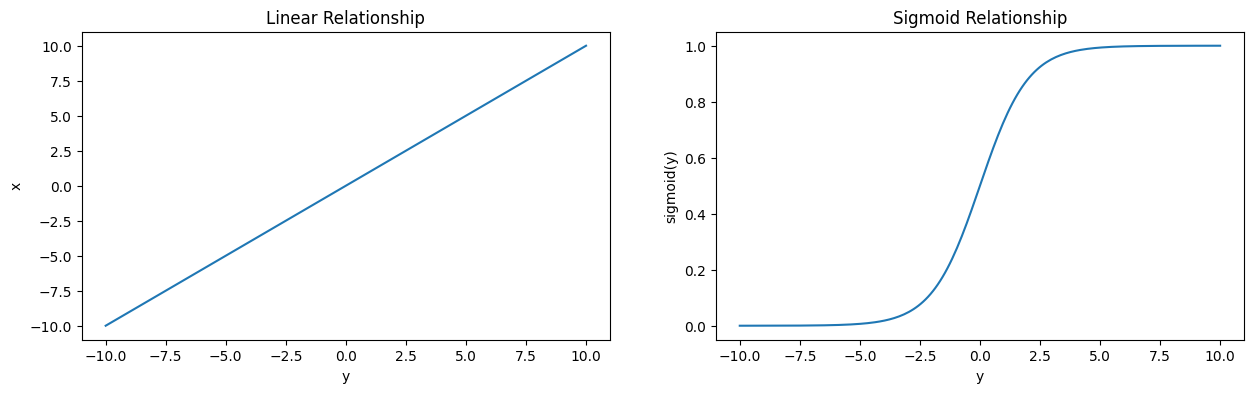

In [34]:
import numpy as np
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(15, 4))

y = np.linspace(-10, 10, 200)  # from negative to positive
x_1 = y
x_2 = 1 / (1 + np.exp(-y))  # correct sigmoid formula

axes[0].plot(y, x_1)
axes[0].set_title("Linear Relationship")
axes[0].set_xlabel("y")
axes[0].set_ylabel("x")

axes[1].plot(y, x_2)
axes[1].set_title("Sigmoid Relationship")
axes[1].set_xlabel("y")
axes[1].set_ylabel("sigmoid(y)")

plt.show()